In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.agents.constant import AllC, AllD
from society.agents.qlearning import DoubleTabularQLearner, TabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.simulations.adaptive import AdaptiveSimulation
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

Run 1:   0%|          | 0/5000 [00:00<?, ?it/s]

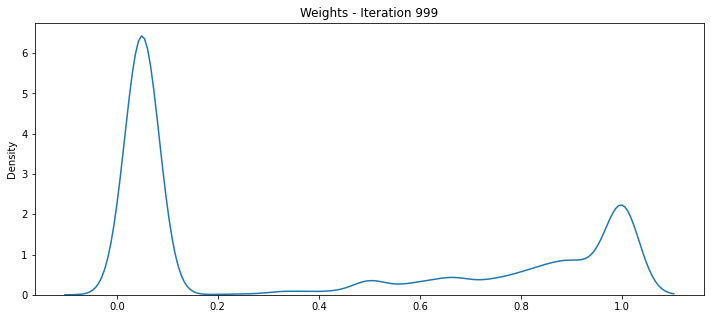

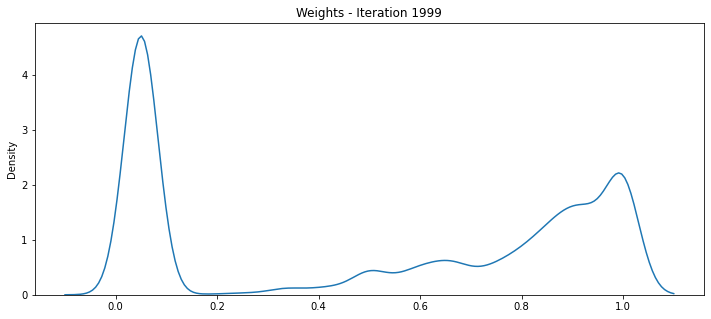

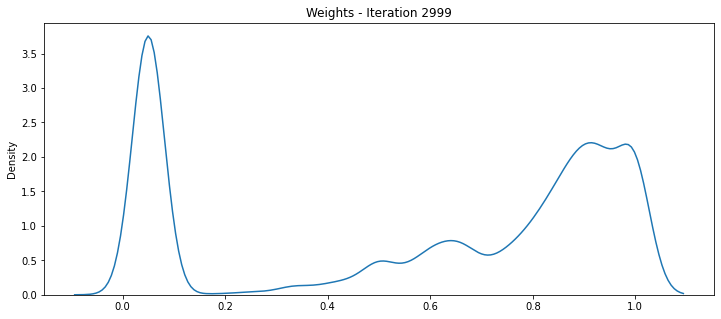

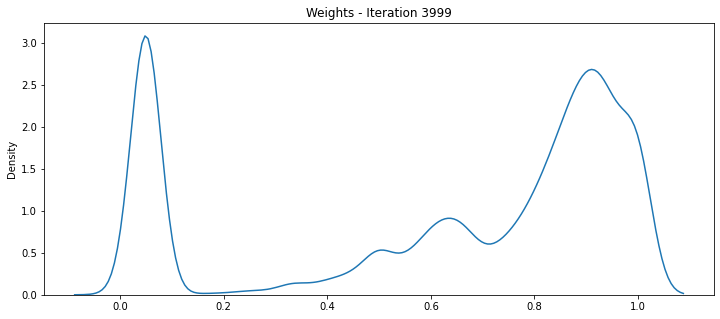

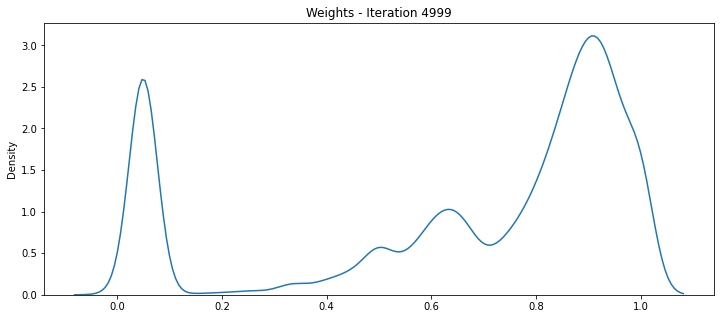

BEST AGENT (403): 31894 (0.6976044799336306, CCDCDCCCDCCCCCCC)
WORST AGENT (237): 24611 (0.5480005385754679, DCDCCCCCCCCCCCCC)


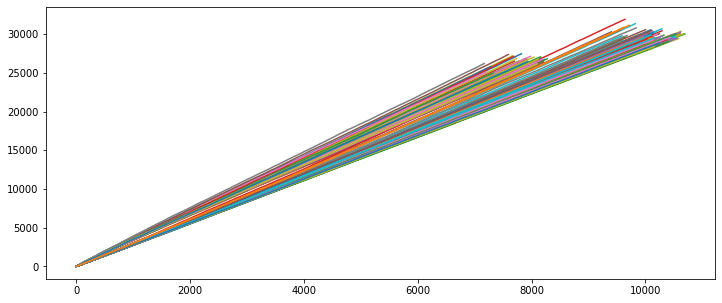

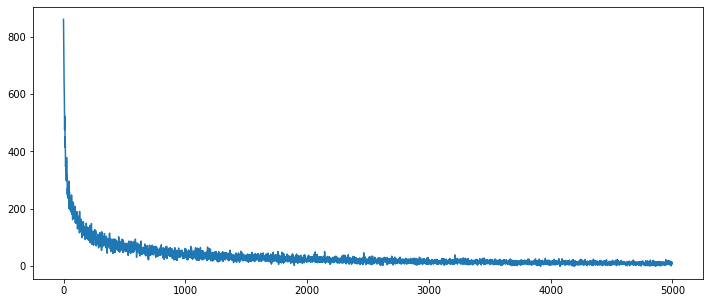

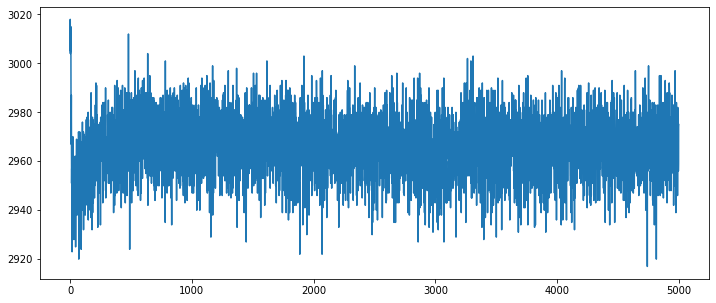

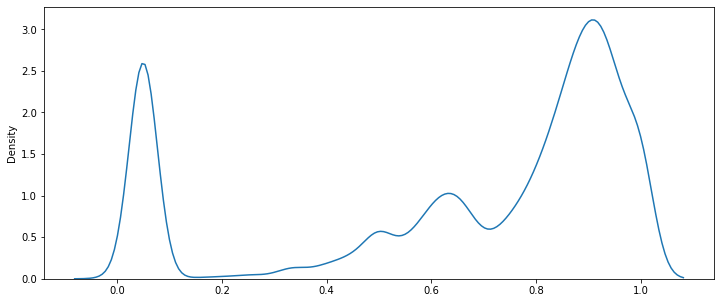

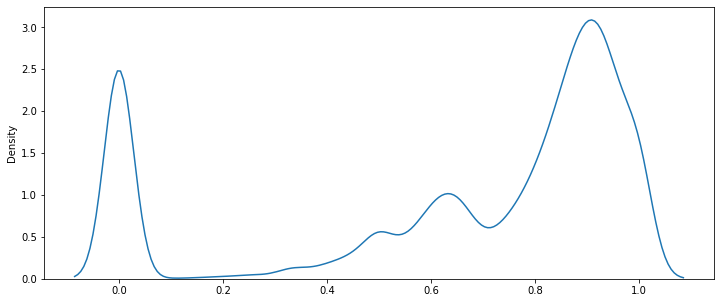

In [4]:
POPULATION = 512
ROUNDS = 5_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []
run_weights = {}
run_coop = {}

for run in range(1):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

        if i % 1000 == 999:
            if i not in run_weights:
                run_weights[i] = []
                run_coop[i] = []

            M = sim.produce_weight_matrix()
            run_weights[i].append(M)

            sns.kdeplot(M.ravel())
            plt.title(f"Weights - Iteration {i}")
            plt.show()

            C = sim.calculate_cooperativeness_proportions()
            run_coop[i].append(C)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()

    M = run_weights[ROUNDS - 1][-1]

    sns.kdeplot(M.ravel())
    plt.show()

    C = run_coop[ROUNDS - 1][-1]

    sns.kdeplot(C.ravel())
    plt.show()


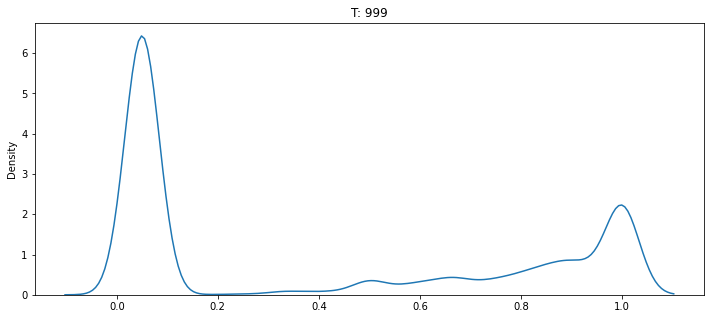

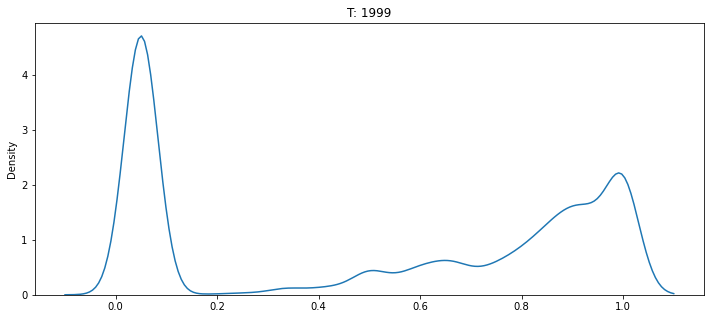

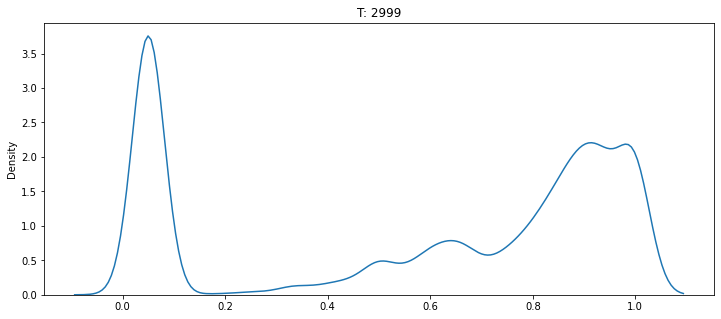

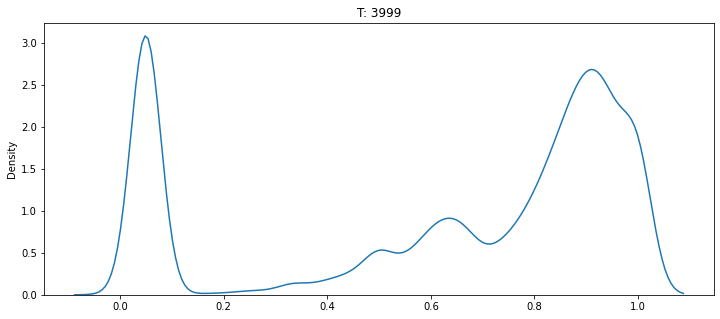

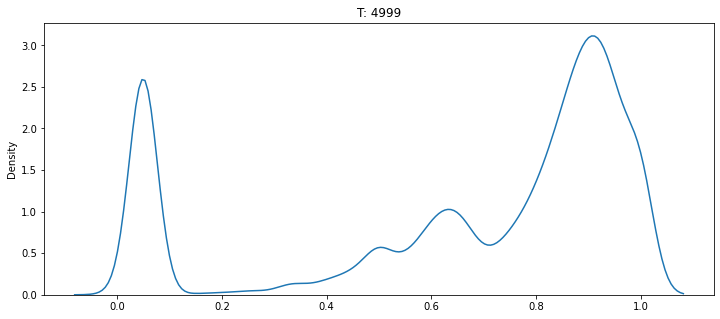

In [5]:
for i in sorted(run_weights.keys()):
    for w in run_weights[i]:
        sns.kdeplot(w.ravel())

    plt.title(f"T: {i}")
    plt.show()

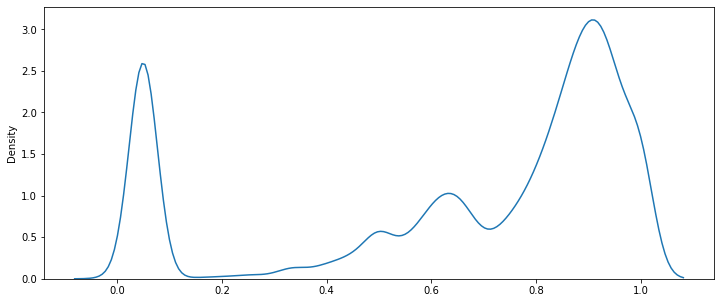

In [6]:
from itertools import chain

sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_weights[ROUNDS - 1]])))
plt.show()

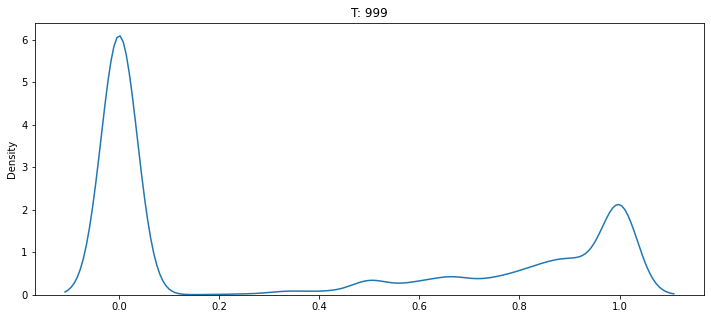

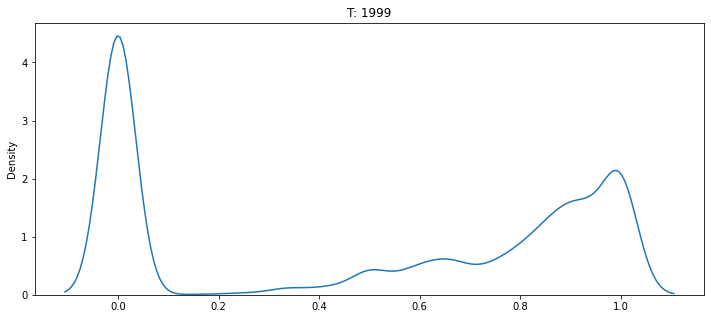

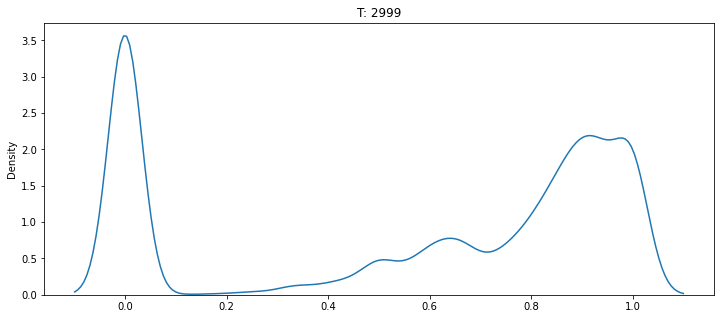

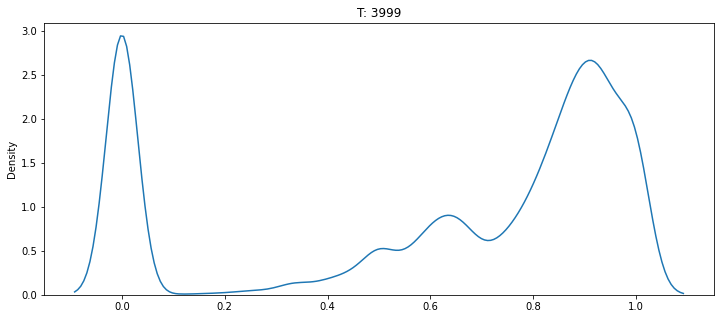

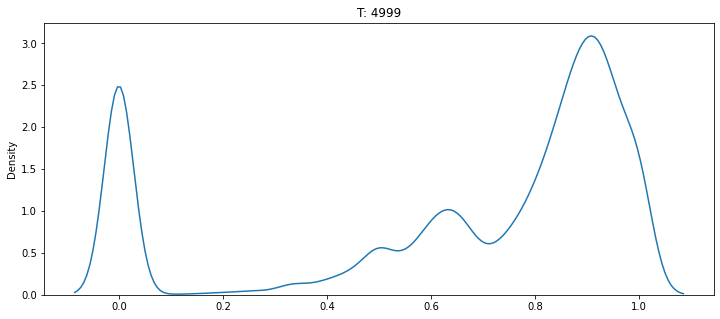

In [7]:
for i in sorted(run_coop.keys()):
    for w in run_coop[i]:
        sns.kdeplot(w.ravel())

    plt.title(f"T: {i}")
    plt.show()

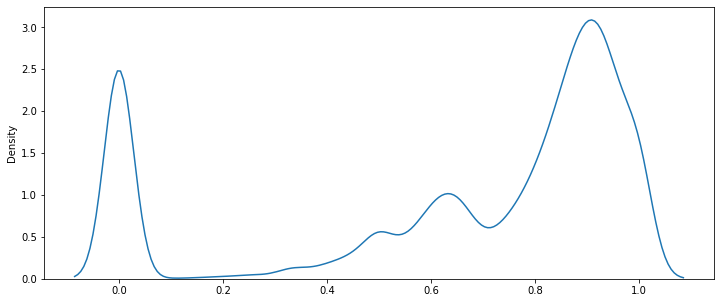

In [8]:
sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_coop[ROUNDS - 1]])))
plt.show()

In [9]:
# G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [10]:
def plot_degree_distribution(G, t):
    degree_sequence = sorted((d for _, d in G.degree()), reverse=True)

    fig = plt.figure(f"Degree of the graph (threshold={t})", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title(f"Connected components of G (threshold={t})")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

0.99	10943	0.10242757611746893
0.975	11367	0.10628495463264248
0.95	18525	0.17742678052585598
0.925	29026	0.28426644841903126
0.9	39258	0.38856845700566656
0.875	49413	0.48848816495197583
0.85	58702	0.576256592007352
0.825	65429	0.6363286076428382
0.8	69429	0.6711500845369249
0.7	80531	0.7413840606507021
0.6	92145	0.7620077142589816
0.5	99028	0.7858365264893926
0.4	105038	0.8085644015008221
0.3	107048	0.820246101343488
0.2	107564	0.8235999196337661
0.1	107810	0.8252783356276611


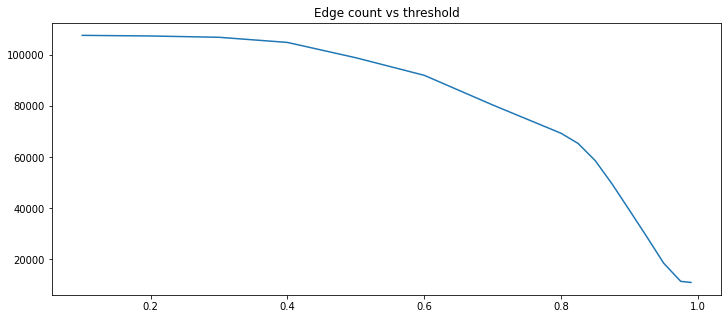

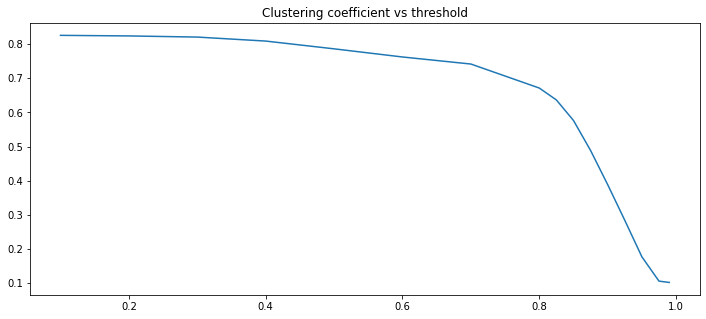

In [11]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

weights = run_weights[ROUNDS - 1][0]

thresholds = [0.99, 0.975, 0.95, 0.925, 0.9, 0.875, 0.85, 0.825, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
edge_counts = []
clustering_coefficients = []

Ks = []

for threshold in thresholds:
    edges = [
        (i, j, (weights[i, j] + weights[j, i]))
        for i in range(POPULATION)
        for j in range(i + 1, POPULATION)
        if i != j and weights[i, j] > threshold and weights[j, i] > threshold
    ]

    K = nx.Graph()
    K.add_weighted_edges_from(edges)
    # nx.drawing.nx_pydot.write_dot(K, f"{dt} - {threshold} - reduced.dot")

    clustering_coefficient = nx.algorithms.cluster.average_clustering(K)
    edge_count = len(edges)

    print(threshold, edge_count, clustering_coefficient, sep="\t")

    edge_counts.append(edge_count)
    clustering_coefficients.append(clustering_coefficient)

    Ks.append(K)

plt.title("Edge count vs threshold")
plt.plot(thresholds, edge_counts)
plt.show()

plt.title("Clustering coefficient vs threshold")
plt.plot(thresholds, clustering_coefficients)
plt.show()

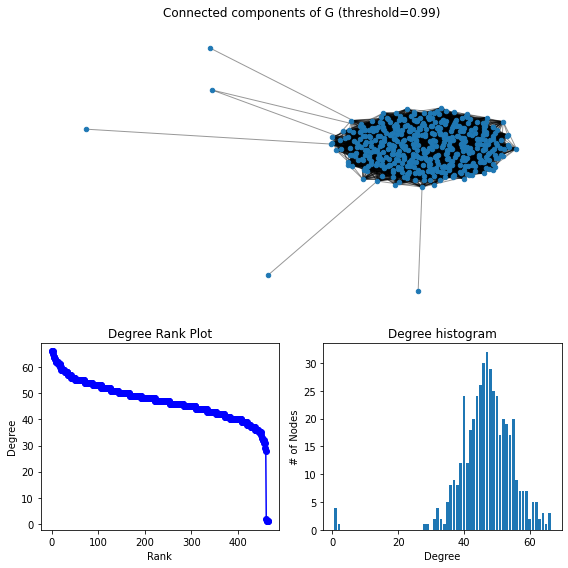

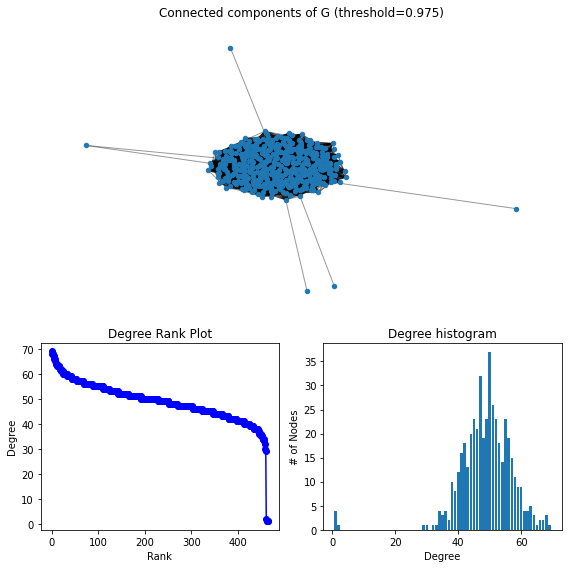

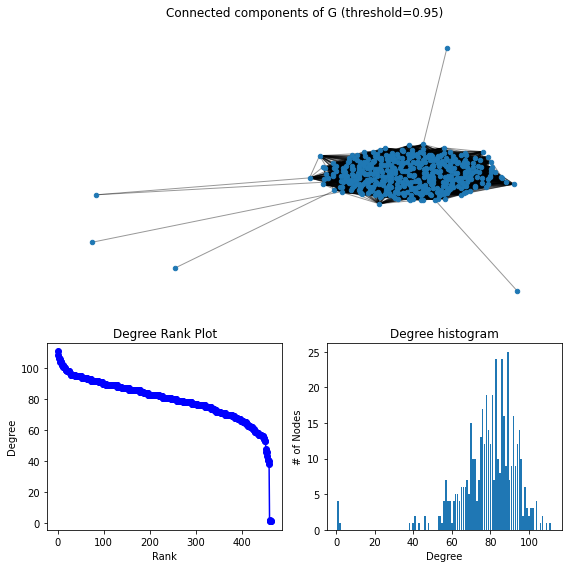

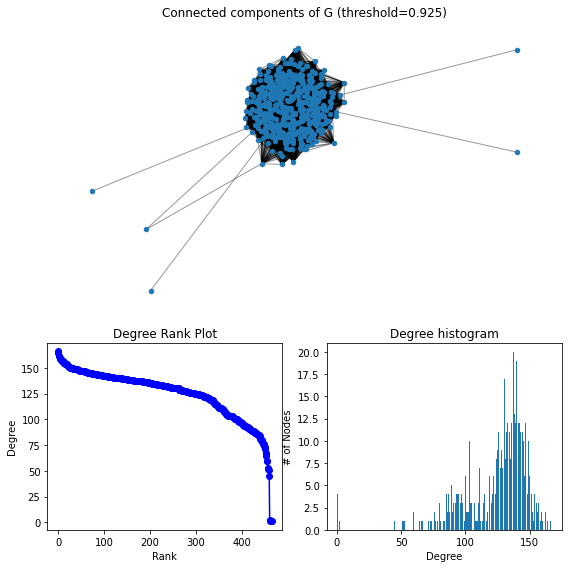

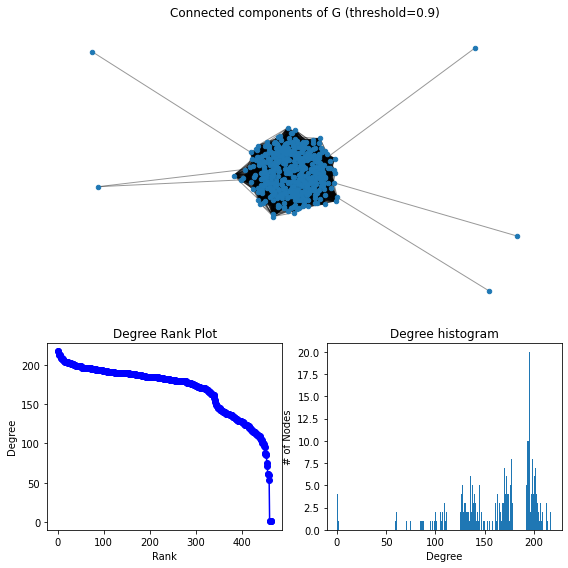

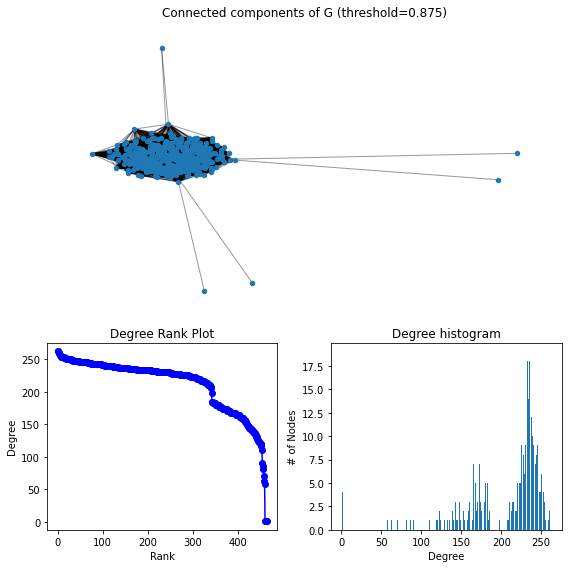

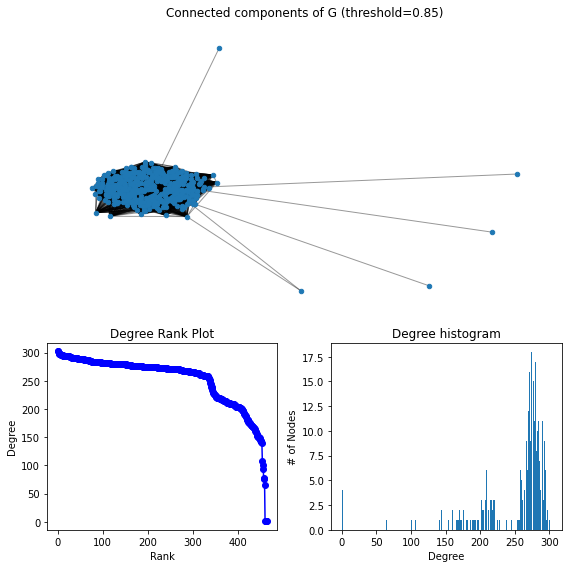

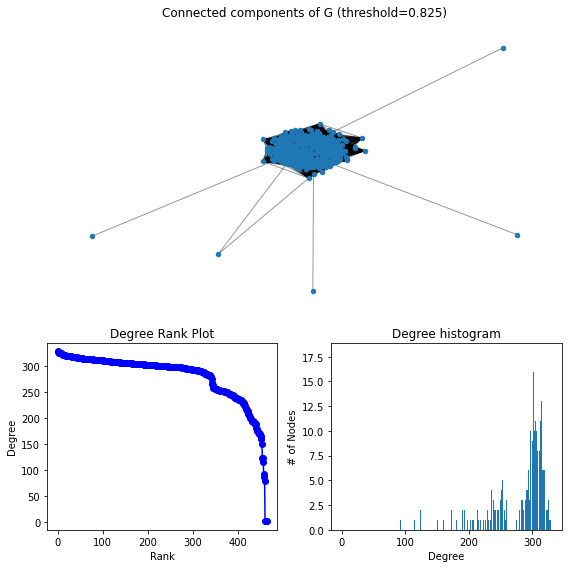

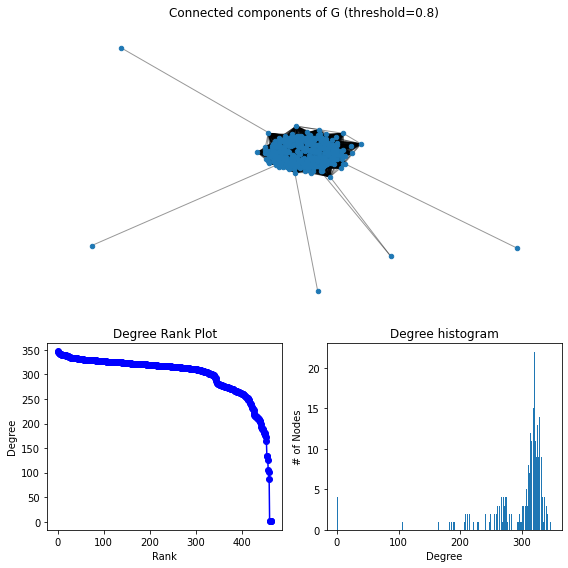

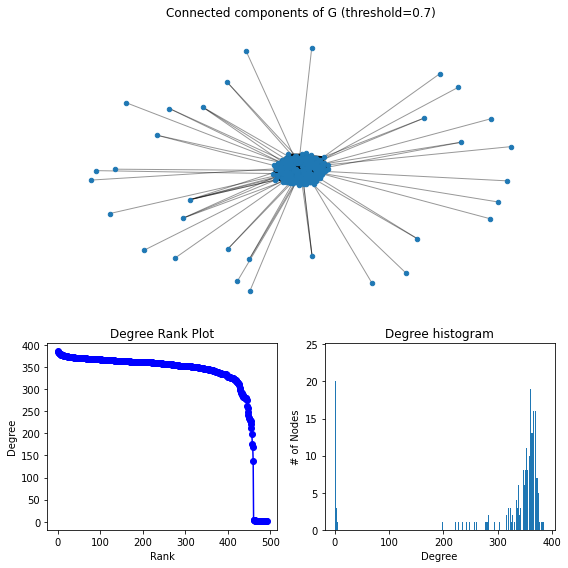

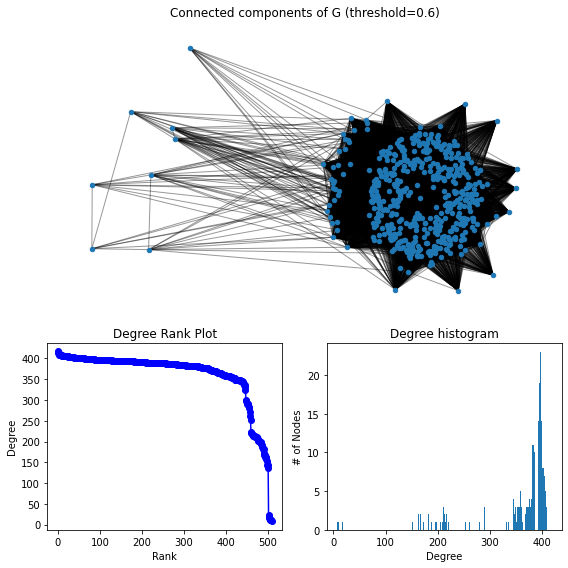

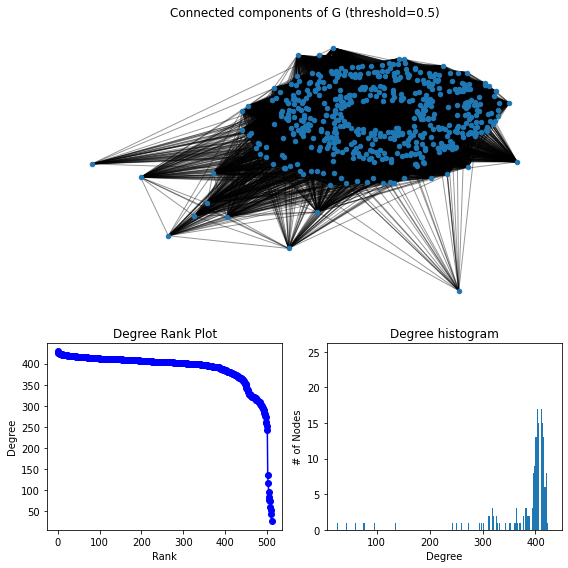

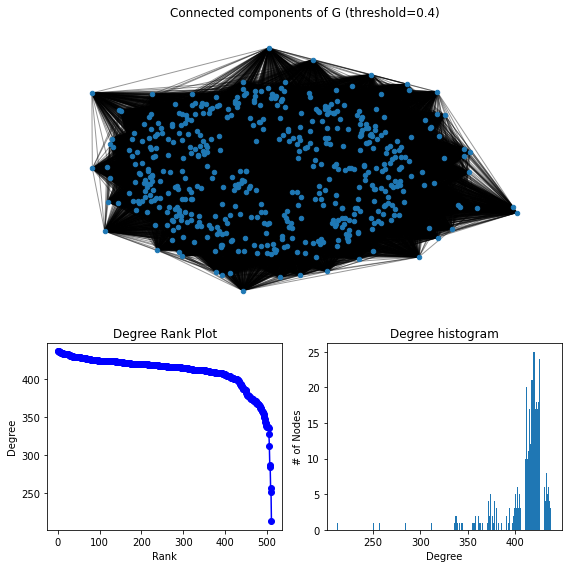

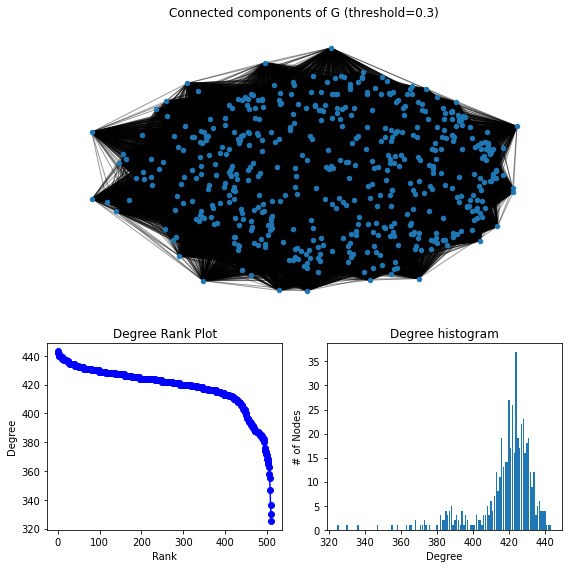

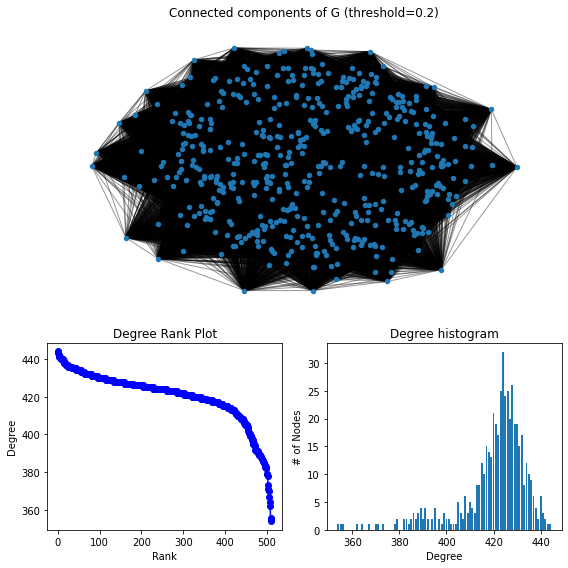

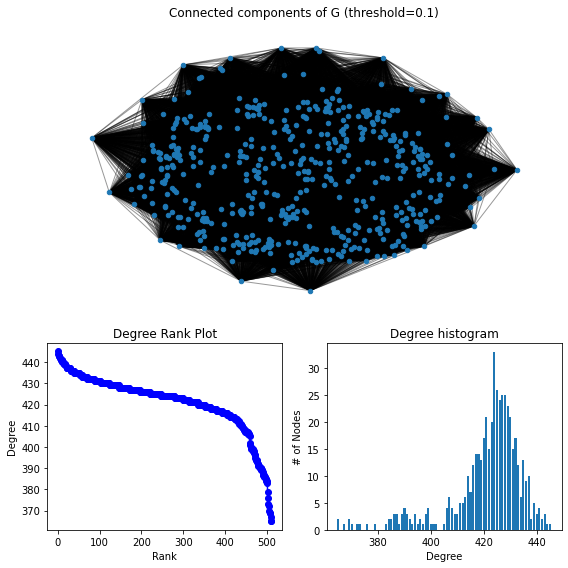

In [12]:
for threshold, K in zip(thresholds, Ks):
    plot_degree_distribution(K, threshold)